## Exercise 3: Using Keras to Build and Train Neural Networks


This exercise is based on Intel's course at: https://software.intel.com/content/dam/develop/public/us/en/downloads/intel-dl101-class5.zip and at: https://software.intel.com/content/www/us/en/develop/training/course-deep-learning.html. 

We will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [ ]:
from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
## Load in the data set (Internet Access needed)
url = 'https://github.com/rosenfa/nn/blob/master/pima-indians-diabetes.csv?raw=true'
diabetes_df = pd.read_csv(url, header = 0, error_bad_lines = False)

In [ ]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
414,0,138,60,35,167,34.6,0.534,21,1
82,7,83,78,26,71,29.3,0.767,36,0
233,4,122,68,0,0,35.0,0.394,29,0
224,1,100,66,15,56,23.6,0.666,26,0
350,4,92,80,0,0,42.2,0.237,29,0


In [ ]:
X = np.asarray(diabetes_df.drop('Outcome',1))
y = np.asarray(diabetes_df['Outcome'])

In [ ]:
# Split the data to Train, and Test (75%, 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 11111)

In [ ]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [ ]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.766
roc-auc is 0.818


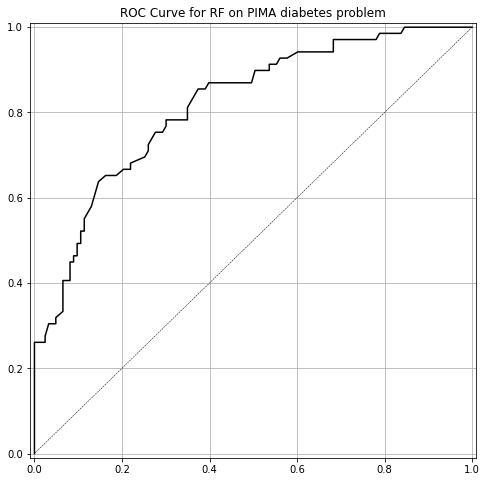

In [ ]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [ ]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

Keras has many shapes.  See: https://keras.io/api/layers/core_layers/dense/ for information about "dense" and sequential means a "basic" ordering (as opposed to more complicated ones we'll learn about starting next week).

In [ ]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [ ]:
#  This is a nice tool to view the model you have created and count the parameters
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?
Think about why there are 108 parameters in first layer when only 8 features exist and the network has 12 nodes (8*12 is NOT 108), and why the output layer has 13 values for only 12 nodes.


Let's fit our model for 200 epochs.

In [ ]:
# Fit(Train) the Model
from tensorflow.keras.optimizers import SGD
# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003, momentum=0.8), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=50)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/50
18/18 [==============================] - 1s 20ms/step - loss: 0.8353 - accuracy: 0.4479 - val_loss: 0.8186 - val_accuracy: 0.4375
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7623 - accuracy: 0.5243 - val_loss: 0.7556 - val_accuracy: 0.5365
Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 0.7054 - accuracy: 0.5764 - val_loss: 0.7136 - val_accuracy: 0.5573
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6655 - accuracy: 0.6233 - val_loss: 0.6828 - val_accuracy: 0.6146
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.6510 - val_loss: 0.6596 - val_accuracy: 0.6250
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6145 - accuracy: 0.6615 - val_loss: 0.6412 - val_accuracy: 0.6354
Epoch 7/50
18/18 [==============================] - 0s 9ms/step - loss: 0.5968 - accuracy: 0.6823 - val_loss: 0.6271 - val_accuracy: 0.6406
Epoch 8/50
18/18 [=

In [ ]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = np.rint(y_pred_prob_nn_1)


In [ ]:
y_pred_prob_nn_1[:10]

array([[0.39512527],
       [0.69623584],
       [0.40771824],
       [0.41074342],
       [0.20776996],
       [0.54570735],
       [0.03922996],
       [0.369439  ],
       [0.8454888 ],
       [0.19672036]], dtype=float32)

In [ ]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

accuracy is 0.745
roc-auc is 0.807


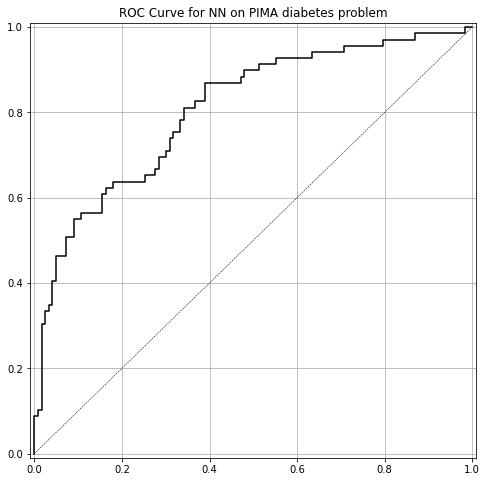

In [ ]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results similar to the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [ ]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

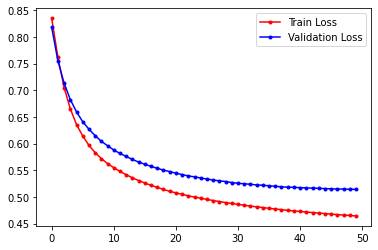

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 450 more epochs.

In [ ]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=450)

Epoch 1/450
18/18 [==============================] - 0s 7ms/step - loss: 0.4636 - accuracy: 0.7535 - val_loss: 0.5139 - val_accuracy: 0.7448
Epoch 2/450
18/18 [==============================] - 0s 7ms/step - loss: 0.4628 - accuracy: 0.7535 - val_loss: 0.5137 - val_accuracy: 0.7448
Epoch 3/450
18/18 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.7535 - val_loss: 0.5134 - val_accuracy: 0.7448
Epoch 4/450
18/18 [==============================] - 0s 7ms/step - loss: 0.4610 - accuracy: 0.7535 - val_loss: 0.5134 - val_accuracy: 0.7448
Epoch 5/450
18/18 [==============================] - 0s 4ms/step - loss: 0.4604 - accuracy: 0.7552 - val_loss: 0.5131 - val_accuracy: 0.7448
Epoch 6/450
18/18 [==============================] - 0s 4ms/step - loss: 0.4596 - accuracy: 0.7552 - val_loss: 0.5133 - val_accuracy: 0.7448
Epoch 7/450
18/18 [==============================] - 0s 5ms/step - loss: 0.4589 - accuracy: 0.7552 - val_loss: 0.5128 - val_accuracy: 0.7500
Epoch 8/450
1

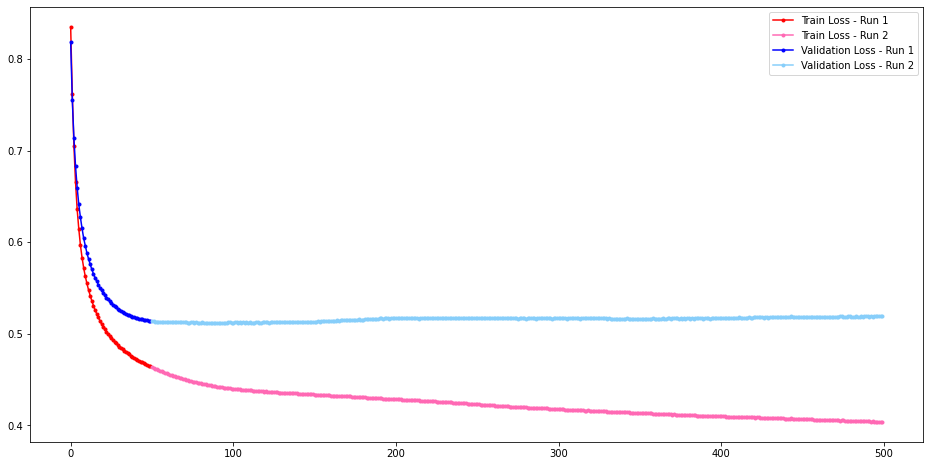

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

accuracy is 0.760
roc-auc is 0.814


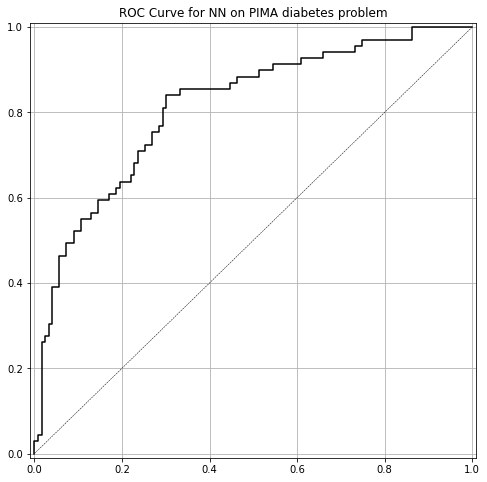

In [ ]:
y_pred_prob_nn_2 = model_1.predict(X_test_norm)
y_pred_class_nn_2 = np.rint(y_pred_prob_nn_2)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model, model_2, with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 100 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

You might want to look at the Keras documentation at: 
https://keras.io/guides/sequential_model/

Experiment with one network with 3 layers and save it as model_3. Did it work better?
Did using more or less epochs help?
Trying different learning rates for model_3.  Did that work better?

##Model 2: two hidden layers

*Define model_2 with two hidden layers, each with 6 nodes, using the relu activation for the hidden layers, and sigmoid for the output layer:*

(Input size is 8-dimensional)

In [ ]:
model_2 = Sequential([
    Dense(6, input_shape = (8,), activation = "relu"),
    Dense(6, activation = "relu"),
    Dense(1, activation = "sigmoid")
])

model_2.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 6)                 54        
                                                                 
 dense_190 (Dense)           (None, 6)                 42        
                                                                 
 dense_191 (Dense)           (None, 1)                 7         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


*Compile and train the model using learning rate of 0.003 and 100 epochs:*

In [ ]:
model_2.compile(SGD(lr = .003, momentum = 0.8), "binary_crossentropy", metrics = ["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data = (X_test_norm, y_test), epochs = 100)

Epoch 1/100
18/18 [==============================] - 1s 11ms/step - loss: 0.8009 - accuracy: 0.4132 - val_loss: 0.7768 - val_accuracy: 0.4062
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7503 - accuracy: 0.4531 - val_loss: 0.7355 - val_accuracy: 0.4740
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5556 - val_loss: 0.7073 - val_accuracy: 0.6094
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.6372 - val_loss: 0.6858 - val_accuracy: 0.6198
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6632 - val_loss: 0.6683 - val_accuracy: 0.6406
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6649 - val_loss: 0.6551 - val_accuracy: 0.6458
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6632 - val_loss: 0.6431 - val_accuracy: 0.6458
Epoch 8/100


*Plot training and validation loss over the different epochs:*

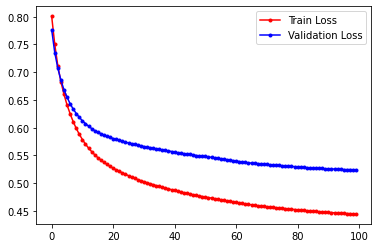

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"], 'r', marker = '.', label = "Train Loss")
ax.plot(run_hist_2.history["val_loss"], 'b', marker = '.', label = "Validation Loss")
ax.legend()

*Plot training and validation accuracy over the different epochs:*

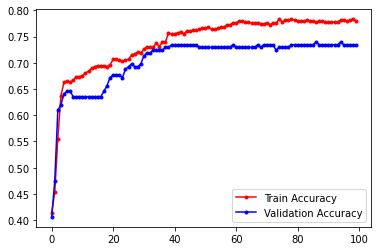

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history['accuracy'], 'r', marker = '.', label = "Train Accuracy")
ax.plot(run_hist_2.history['val_accuracy'], 'b', marker='.', label = "Validation Accuracy")
ax.legend()

*Print the model performance and plot the ROC curve for the predictions:*

accuracy is 0.734
roc-auc is 0.802


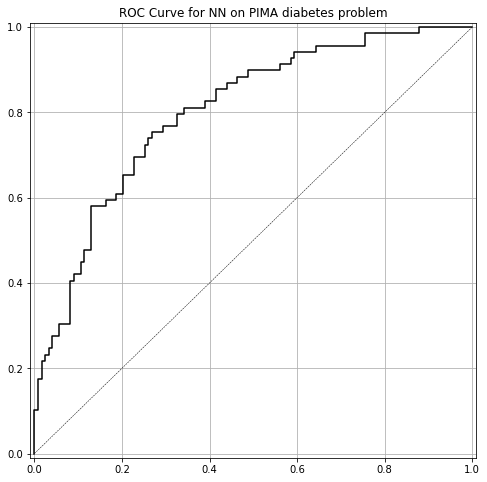

In [ ]:
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
y_pred_class_nn_2 = np.rint(y_pred_prob_nn_2)

print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

##Model 3: three hidden layers

*Define model_3 with three hidden layers, each with different number of nodes, using the relu activation for the hidden layers, and sigmoid for the output layer:*

In [ ]:
model_3 = Sequential([
    Dense(6, input_shape = (8,), activation = "relu"),
    Dense(12, activation = "relu"),
    Dense(3, activation = "relu"),
    Dense(1, activation = "sigmoid")
])

model_3.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 6)                 54        
                                                                 
 dense_193 (Dense)           (None, 12)                84        
                                                                 
 dense_194 (Dense)           (None, 3)                 39        
                                                                 
 dense_195 (Dense)           (None, 1)                 4         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


*Compile and train the model using learning rate of 0.003 and 100 epochs:*

In [ ]:
model_3.compile(SGD(lr = .003, momentum = 0.8), "binary_crossentropy", metrics = ["accuracy"])
run_hist_3 = model_3.fit(X_train_norm, y_train, validation_data = (X_test_norm, y_test), epochs = 100)

Epoch 1/100
18/18 [==============================] - 1s 12ms/step - loss: 0.7335 - accuracy: 0.4271 - val_loss: 0.7094 - val_accuracy: 0.4635
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7050 - accuracy: 0.5417 - val_loss: 0.6871 - val_accuracy: 0.5677
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.6215 - val_loss: 0.6721 - val_accuracy: 0.6458
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.6632 - val_loss: 0.6614 - val_accuracy: 0.6771
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6823 - val_loss: 0.6524 - val_accuracy: 0.6823
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6910 - val_loss: 0.6452 - val_accuracy: 0.6927
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6944 - val_loss: 0.6389 - val_accuracy: 0.7031
Epoch 8/100


*Plot training and validation loss over the different epochs:*

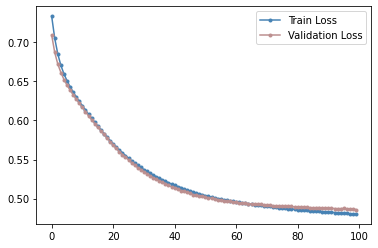

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_3.history["loss"], 'steelblue', marker = '.', label = "Train Loss")
ax.plot(run_hist_3.history["val_loss"], 'rosybrown', marker = '.', label = "Validation Loss")
ax.legend()

*Plot training and validation accuracy over the different epochs:*

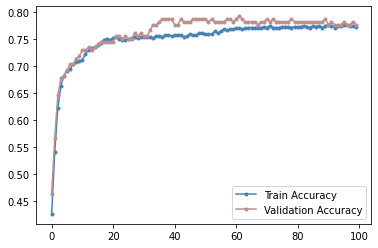

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_3.history['accuracy'], 'steelblue', marker = '.', label = "Train Accuracy")
ax.plot(run_hist_3.history['val_accuracy'],  'rosybrown', marker = '.', label = "Validation Accuracy")
ax.legend()

*Print the model performance and plot the ROC curve for the predictions:*

accuracy is 0.776
roc-auc is 0.837


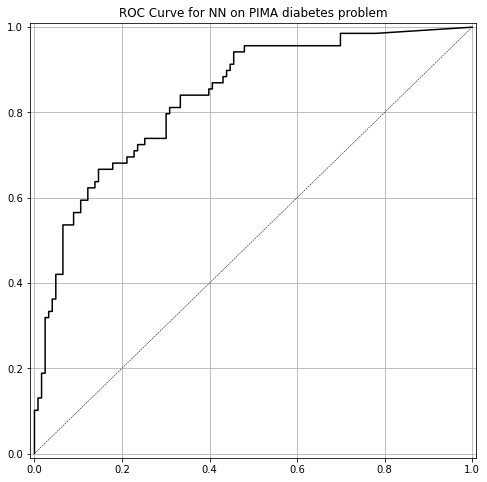

In [ ]:
y_pred_prob_nn_3 = model_3.predict(X_test_norm)
y_pred_class_nn_3 = np.rint(y_pred_prob_nn_3)
model_3_accuracy = accuracy_score(y_test, y_pred_class_nn_3)

print('accuracy is {:.3f}'.format(model_3_accuracy))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_3)))

plot_roc(y_test, y_pred_prob_nn_3, 'NN')

**Conclusion: the three layers model workes better than the two layers model - both the accuracy and the area uder the ROC curve are higher here.**

(Note: this conclusion is based on the results we usually get, though a few times we got a higher accuracy for model_2).

Here, we compare the accuracy distribution of different number of hidden layers. We use the train history variable.

(We don't show model_1 distribution since the number of epochs was different).

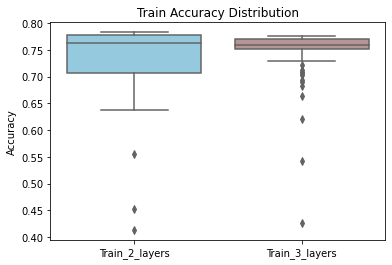

In [ ]:
# create wide-form data of the train accuracy 
d = {'Train_2_layers': run_hist_2.history['accuracy'], 'Train_3_layers': run_hist_3.history['accuracy']}
data = pd.DataFrame.from_dict(d, orient = 'index').transpose()

# train accuracy box plot - 1 hidden layer vs. 2 hidden layers vs. 3 hidden layers
ax = sns.boxplot(data = data[['Train_2_layers', 'Train_3_layers']], palette = ['skyblue', 'rosybrown','lavender']).set(title = 'Train Accuracy Distribution' , ylabel = 'Accuracy')
plt.show()

Now we try more or less epochs and different learning rates for model_3, to see if it works better.

In [ ]:
# This function defines a new model, compiles and fits it using the given learning rate and nuber of epochs, and then returns the model accuracy
# Since the fit method picks up where it left off, we need to define a new model every time

def accuracy_of_model(lr, epochs):
  
  model = Sequential([
    Dense(6, input_shape = (8,), activation = "relu"),
    Dense(12, activation = "relu"),
    Dense(3, activation = "relu"),
    Dense(1, activation = "sigmoid")
  ])

  model.compile(SGD(lr = lr, momentum = 0.8), "binary_crossentropy", metrics = ["accuracy"])
  model.fit(X_train_norm, y_train, validation_data = (X_test_norm, y_test), epochs = epochs)

  y_pred_prob_nn = model.predict(X_test_norm)
  y_pred_class_nn = np.rint(y_pred_prob_nn)
  accuracy = accuracy_score(y_test, y_pred_class_nn)

  return 'The model accuracy for learning rate = {:.3f} and epochs = {:1d}: {:.3f}.'.format(lr, epochs, accuracy)

*Run the model with different values:*

In [ ]:
different_epochs_output = [accuracy_of_model(0.003, 200), accuracy_of_model(0.003, 50)]
different_lr_output = [accuracy_of_model(0.005, 100), accuracy_of_model(0.001, 100)]

Epoch 1/200
18/18 [==============================] - 1s 11ms/step - loss: 0.7003 - accuracy: 0.4757 - val_loss: 0.6970 - val_accuracy: 0.5417
Epoch 2/200
18/18 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5903 - val_loss: 0.6894 - val_accuracy: 0.5677
Epoch 3/200
18/18 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.6181 - val_loss: 0.6834 - val_accuracy: 0.5938
Epoch 4/200
18/18 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.6285 - val_loss: 0.6783 - val_accuracy: 0.6250
Epoch 5/200
18/18 [==============================] - 0s 5ms/step - loss: 0.6737 - accuracy: 0.6406 - val_loss: 0.6744 - val_accuracy: 0.6406
Epoch 6/200
18/18 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.6510 - val_loss: 0.6710 - val_accuracy: 0.6406
Epoch 7/200
18/18 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.6510 - val_loss: 0.6679 - val_accuracy: 0.6406
Epoch 8/200


In [ ]:
# Print the accuracy of the original model_3
print('The model accuracy for learning rate = 0.003 and epochs = 100: {:.3f}.'.format(model_3_accuracy))

The model accuracy for learning rate = 0.003 and epochs = 100: 0.776.


*Try more or less epochs:*

In [ ]:
for sentence in different_epochs_output:
  print(sentence)

The model accuracy for learning rate = 0.003 and epochs = 200: 0.766.
The model accuracy for learning rate = 0.003 and epochs = 50: 0.641.


**As we expected, less epochs decreases the accuracy. More epochs does not make a big difference.**

*Try different learning rates:*

In [ ]:
for sentence in different_lr_output:
  print(sentence)

The model accuracy for learning rate = 0.005 and epochs = 100: 0.740.
The model accuracy for learning rate = 0.001 and epochs = 100: 0.750.


**Different learning rate, either higher or lower, does not work better for model_3.**


**Conclusion: our original values, learning rate = 0.003 and epochs = 100, work good for model_3.**

(Note: again, this conclusion is based on the results we get most of the time).